# 미션 소개

Hugging Face transformers 라이브러리를 사용하여 문서 요약 모델을 구현하는 미션.
데이터 로드 및 전처리부터 모델 실행, 결과 평가까지 전체 파이프라인을 구축.

## 사용 데이터셋
- 데이터 형식
    - JSON 파일 형태로 제공되며, 3종류(신문 기사, 사설, 법률)의 문서가 포함되어 있다.
- 데이터 구성
    - 각 문서 타입은 train/test 쌍으로 구성되어 있으며, 전체 데이터를 모두 사용하거나 원하는 문서 종류를 선택하여 학습시키면 된다.

## 가이드라인
- 데이터 로드 및 전처리
    - 문서 데이터를 로드하고, 불필요한 기호나 공백을 제거하는 등 전처리 작업을 수행
    - 텍스트 길이를 확인하고, 모델 입력에 적합한 형식으로 변환한다.
- 모델 선택 및 실행
    - Hugging Face의 Transformers 라이브러리를 활용해 문서 요약을 수행
    - 사전 학습된 모델을 활용하거나 주어진 데이터를 가지고 Fine-tuning 하기.
- 모델 평가 및 결과 분석
    - 생성된 요약문과 원본 문서를 비교하여 ROUGE 등의 평가 지표를 사용해 요약 품질을 분석한다.
    - 테스트 문장에 대한 요약 결과를 출력하여 모델의 성능을 확인한다.
- 모델 구현 및 학습 결과
    - 문서 요약 모델(예: Transformer 기반 요약 모델, T5, BART 등)을 구현하고, 데이터 로드 → 전처리 → 모델 구축 및 학습 → 요약 생성 및 평가 과정을 순차적으로 진행.
- 모델 성능 평가 및 제출
    - 생성된 요약문의 품질을 정성적(요약 결과 확인) 및 정량적(ROUGE 등)으로 평가.
    - 테스트 데이터셋에 대한 요약 결과를 포함
- 원본 데이터셋 링크
    - https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=97

# 환경 설정

In [16]:
!pip install transformers datasets
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 37.4 MB/s eta 0:00:00


In [17]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pickle
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from konlpy.tag import Okt
import nltk
from nltk.tokenize import word_tokenize

## GPU 세팅

In [18]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("CUDA available:", torch.cuda.is_available())

if torch.backends.mps.is_available():
    device = torch.device("mps")  # 맥북 M1/M2 GPU
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (Colab, Windows 등)
    print("Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")   # CPU fallback
    print("Using CPU")

print("Selected device:", device)

PyTorch: 2.8.0+cu126
MPS available: False
CUDA available: True
Using CUDA (NVIDIA GPU)
Selected device: cuda


In [19]:
import zipfile
import os

zip_file_path = '/content/summarization.zip'
extract_dir = './'  # 압축 해제할 디렉토리

# 디렉토리가 없으면 생성
os.makedirs(extract_dir, exist_ok=True)

# zip 파일 열고 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ '{zip_file_path}' 파일이 '{extract_dir}' 경로에 성공적으로 압축 해제되었습니다.")

# 압축 해제된 파일 목록 확인 (선택 사항)
print("\n=== 압축 해제된 파일 목록 ===")
for root, dirs, files in os.walk(extract_dir):
    for name in files:
        print(os.path.join(root, name))

✅ '/content/summarization.zip' 파일이 './' 경로에 성공적으로 압축 해제되었습니다.

=== 압축 해제된 파일 목록 ===
./summarization.zip
./checkpoint-16887.zip
./.config/gce
./.config/.last_survey_prompt.yaml
./.config/active_config
./.config/default_configs.db
./.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
./.config/.last_update_check.json
./.config/config_sentinel
./.config/.last_opt_in_prompt.yaml
./.config/logs/2025.08.28/13.42.40.032629.log
./.config/logs/2025.08.28/13.42.14.257094.log
./.config/logs/2025.08.28/13.42.24.254751.log
./.config/logs/2025.08.28/13.42.30.169478.log
./.config/logs/2025.08.28/13.41.44.528882.log
./.config/logs/2025.08.28/13.42.40.767285.log
./.config/configurations/config_default
./summarization/valid_original_editorial.json
./summarization/valid_original_news.json
./summarization/train_original_law.json
./summarization/train_original_editorial.json
./summarization/train_original_news.json
./summarization/valid_original_law.json
./results/checkpoint-16887/rng_st

# KoBART 모델

In [20]:
# KoBART 모델 다운로드
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print("=== gogamza/kobart-base-v2 모델 다운로드 중 ===")

# 토크나이저 다운로드 (models 폴더에 저장)
tokenizer = AutoTokenizer.from_pretrained('gogamza/kobart-base-v2', cache_dir='./models')
print("✅ 토크나이저 다운로드 완료!")

# 모델 다운로드 (models 폴더에 저장)
model = AutoModelForSeq2SeqLM.from_pretrained('gogamza/kobart-base-v2', cache_dir='./models')
print("✅ 모델 다운로드 완료!")

# 모델 정보 출력
print(f"\n�� 모델 정보:")
print(f"- 토크나이저 타입: {type(tokenizer).__name__}")
print(f"- 모델 타입: {type(model).__name__}")
print(f"- 어휘 크기: {tokenizer.vocab_size:,}")
print(f"- 모델 파라미터: {sum(p.numel() for p in model.parameters()):,}")

# 모델을 디바이스로 이동
model = model.to(device)
print(f"\n�� 모델이 {device} 디바이스로 이동되었습니다!")

=== gogamza/kobart-base-v2 모델 다운로드 중 ===


config.json: 0.00B [00:00, ?B/s]

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


✅ 토크나이저 다운로드 완료!


model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

✅ 모델 다운로드 완료!

�� 모델 정보:
- 토크나이저 타입: PreTrainedTokenizerFast
- 모델 타입: BartForConditionalGeneration
- 어휘 크기: 30,000
- 모델 파라미터: 123,859,968

�� 모델이 cuda 디바이스로 이동되었습니다!


# 데이터 로드 및 전처리

## 1. 데이터 로드 및 전처리 함수

In [21]:
# 데이터 로드 및 전처리 함수
def load_json_dataset(file_path):
    """JSON 파일을 로드하여 문서별 text, summary 정보를 추출"""
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    examples = []
    for doc in data["documents"]:
        sentences = []
        # "text"는 중첩 리스트 형태이므로 내부의 모든 sentence를 추출
        for sublist in doc["text"]:
            for item in sublist:
                sentences.append(item.get("sentence", ""))

        full_text = " ".join(sentences)
        # abstractive 요약은 첫번째 항목 사용 (없으면 빈 문자열)
        summary = doc["abstractive"][0] if doc["abstractive"] else ""

        examples.append({
            "text": full_text,
            "summary": summary,
        })

    return examples

## 2. 데이터셋 로드

In [22]:
# 데이터 경로 설정
base_path = "./summarization/"

# 처음에는 작은 법률 데이터셋으로 시작
train_file = "train_original_law.json"
valid_file = "valid_original_law.json"

print("=== 데이터 로드 중 ===")
train_examples = load_json_dataset(os.path.join(base_path, train_file))
valid_examples = load_json_dataset(os.path.join(base_path, valid_file))

print(f"훈련 데이터: {len(train_examples):,}개")
print(f"검증 데이터: {len(valid_examples):,}개")

# 샘플 데이터 확인
print(f"\n=== 샘플 데이터 ===")
print(f"첫 번째 훈련 예시:")
print(f"텍스트 길이: {len(train_examples[0]['text'])}자")
print(f"요약 길이: {len(train_examples[0]['summary'])}자")
print(f"텍스트 미리보기: {train_examples[0]['text'][:100]}...")
print(f"요약: {train_examples[0]['summary']}")

=== 데이터 로드 중 ===
훈련 데이터: 24,329개
검증 데이터: 3,004개

=== 샘플 데이터 ===
첫 번째 훈련 예시:
텍스트 길이: 372자
요약 길이: 97자
텍스트 미리보기: 원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고, 노조조합장이 사임한 경우, 노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있...
요약: 원고가  주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 따른 징계해고는 사내질서를 유지하기 위한 사용자 고유의 정당한 징계권의 행사로 보아야 한다.


## 3. 데이터 전처리

In [23]:
# 데이터 전처리 함수
def preprocess_data(examples, max_text_length=512, max_summary_length=128):
    """텍스트와 요약을 전처리하고 길이 제한"""
    processed = []

    for example in examples:
        text = example["text"].strip()
        summary = example["summary"].strip()

        # 빈 요약 제거
        if not summary:
            continue

        # 길이 제한
        if len(text) > max_text_length * 3:  # 대략적인 토큰 수 추정
            continue
        if len(summary) > max_summary_length * 3:
            continue

        processed.append({
            "text": text,
            "summary": summary
        })

    return processed

# 데이터 전처리 적용
print("=== 데이터 전처리 중 ===")
train_processed = preprocess_data(train_examples)
valid_processed = preprocess_data(valid_examples)

print(f"전처리 후 훈련 데이터: {len(train_processed):,}개")
print(f"전처리 후 검증 데이터: {len(valid_processed):,}개")

=== 데이터 전처리 중 ===
전처리 후 훈련 데이터: 22,514개
전처리 후 검증 데이터: 2,836개


## 4. Hugging Face Dataset으로 변환

In [24]:
from datasets import Dataset, DatasetDict

# Dataset 객체 생성
train_dataset = Dataset.from_list(train_processed)
valid_dataset = Dataset.from_list(valid_processed)

# DatasetDict 형태로 통합
dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})

print("=== Dataset 변환 완료 ===")
print(f"데이터셋 구조: {dataset}")

=== Dataset 변환 완료 ===
데이터셋 구조: DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 22514
    })
    validation: Dataset({
        features: ['text', 'summary'],
        num_rows: 2836
    })
})


## 5. tokenizing

In [25]:
# 토크나이징 함수
def tokenize_function(example):
    """텍스트와 요약을 토큰화"""
    model_inputs = tokenizer(
        example["text"],
        max_length=512,
        truncation=True,
        padding="max_length"
    )

    labels = tokenizer(
        text_target=example["summary"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 토크나이징 적용
print("=== 토크나이징 중 ===")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

print(f"✅ 토크나이징 완료!")
print(f"토크나이징된 훈련 데이터: {len(tokenized_datasets['train'])}개")
print(f"토크나이징된 검증 데이터: {len(tokenized_datasets['validation'])}개")

=== 토크나이징 중 ===


Map:   0%|          | 0/22514 [00:00<?, ? examples/s]

Map:   0%|          | 0/2836 [00:00<?, ? examples/s]

✅ 토크나이징 완료!
토크나이징된 훈련 데이터: 22514개
토크나이징된 검증 데이터: 2836개


# 모델 학습

## DataCollator 설정

In [ ]:
# DataCollator 설정
from transformers import DataCollatorForSeq2Seq

print("=== DataCollator 설정 중 ===")
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    return_tensors="pt"
)

print("✅ DataCollator 설정 완료!")

=== DataCollator 설정 중 ===
✅ DataCollator 설정 완료!


## 학습 파라미터 설정

In [ ]:
# 학습 파라미터 설정
from transformers import TrainingArguments

print("=== 학습 파라미터 설정 중 ===")

training_args = TrainingArguments(
    output_dir="./results",           # 결과 저장 폴더
    eval_strategy="steps",            # 평가 전략
    eval_steps=500,                   # 500 스텝마다 평가
    save_strategy="steps",            # 저장 전략
    save_steps=1000,                  # 1000 스텝마다 모델 저장
    learning_rate=5e-5,               # 학습률
    per_device_train_batch_size=4,    # 배치 크기 (GPU 메모리에 따라 조정)
    per_device_eval_batch_size=4,     # 평가 배치 크기
    num_train_epochs=3,               # 학습 에포크
    weight_decay=0.01,                # 가중치 감쇠
    logging_dir="./logs",             # 로그 저장 폴더
    logging_steps=100,                # 100 스텝마다 로그
    save_total_limit=3,               # 최대 3개 체크포인트만 저장
    load_best_model_at_end=True,      # 최고 성능 모델 로드
    metric_for_best_model="eval_loss", # 최고 성능 기준
    greater_is_better=False,          # 손실은 낮을수록 좋음
    report_to="none",                 # wandb 등 외부 도구 사용 안함
)

print("✅ 학습 파라미터 설정 완료!")
print(f"학습 에포크: {training_args.num_train_epochs}")
print(f"학습률: {training_args.learning_rate}")
print(f"배치 크기: {training_args.per_device_train_batch_size}")

=== 학습 파라미터 설정 중 ===
✅ 학습 파라미터 설정 완료!
학습 에포크: 3
학습률: 5e-05
배치 크기: 4


## Trainer 설정 및 학습

In [ ]:
# Trainer 설정
from transformers import Trainer

print("=== Trainer 설정 중 ===")

trainer = Trainer(
    model=model,                           # 모델
    args=training_args,                    # 학습 파라미터
    train_dataset=tokenized_datasets["train"],      # 훈련 데이터
    eval_dataset=tokenized_datasets["validation"],  # 검증 데이터
    tokenizer=tokenizer,                   # 토크나이저
    data_collator=data_collator,           # 데이터 콜레이터
)

print("✅ Trainer 설정 완료!")
print(f"훈련 데이터 크기: {len(tokenized_datasets['train'])}")
print(f"검증 데이터 크기: {len(tokenized_datasets['validation'])}")

=== Trainer 설정 중 ===
✅ Trainer 설정 완료!
훈련 데이터 크기: 22514
검증 데이터 크기: 2836


/tmp/ipython-input-3876579206.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 모델 학습 시작
print("🚀 모델 학습 시작!")
print("=" * 50)

# 학습 실행
train_result = trainer.train()

print("✅ 학습 완료!")
print(f"총 학습 시간: {train_result.metrics['train_runtime']:.2f}초")
print(f"총 학습 스텝: {train_result.metrics['train_steps']}")
print(f"최종 손실: {train_result.metrics['train_loss']:.4f}")

🚀 모델 학습 시작!


Step,Training Loss,Validation Loss
500,0.881400,0.735408
1000,0.809700,0.704506
1500,0.787100,0.685558
2000,0.791800,0.672039
2500,0.776200,0.665626
3000,0.750600,0.653747
3500,0.722200,0.657478
4000,0.745300,0.650298
4500,0.728000,0.637452
5000,0.747100,0.639258


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'forced_eos_token_id': 1}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


✅ 학습 완료!
총 학습 시간: 7778.11초


KeyError: 'train_steps'

In [ ]:
print("✅ 학습 완료!")
print(f"총 학습 시간: {train_result.metrics['train_runtime']:.2f}초")
# print(f"총 학습 스텝: {train_result.metrics['train_steps']}") # This key caused an error
print(f"최종 손실: {train_result.metrics['train_loss']:.4f}")

# Print all available keys in train_result.metrics to help debugging
print("\nAvailable metrics keys:")
for key in train_result.metrics.keys():
    print(f"- {key}")

✅ 학습 완료!
총 학습 시간: 7778.11초
최종 손실: 0.6341

Available metrics keys:
- train_runtime
- train_samples_per_second
- train_steps_per_second
- total_flos
- train_loss
- epoch


In [26]:
from transformers import pipeline

# 모델과 토크나이저를 사용하여 요약 파이프라인 생성
# device=0 는 첫 번째 GPU를 사용하겠다는 의미입니다 (CUDA 사용 시)
summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1 # GPU 사용 가능하면 사용, 아니면 CPU 사용
)

# 검증 데이터셋에서 첫 번째 예제 가져오기
example = valid_processed[0]
original_text = example["text"]
reference_summary = example["summary"]

print("=== 요약 테스트 시작 ===")
print(f"원본 텍스트:\n{original_text[:500]}...") # 긴 텍스트는 일부만 출력
print(f"\n참조 요약:\n{reference_summary}")

# 요약 생성
generated_summary = summarizer(original_text, max_length=128, min_length=30, do_sample=False)[0]['summary_text']

print(f"\n생성된 요약:\n{generated_summary}")
print("=== 요약 테스트 완료 ===")

Device set to use cuda:0


=== 요약 테스트 시작 ===
원본 텍스트:
[1] 취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고, 처분 등이 있은 날부터 1년을 경과하면 제기하지 못하며( 행정소송법 제20조 제1항, 제2항), 청구취지를 변경하여 구 소가 취하되고 새로운 소가 제기된 것으로 변경되었을 때에 새로운 소에 대한 제소기간의 준수 등은 원칙적으로 소의 변경이 있은 때를 기준으로 하여야 한다. [2] 일반적으로 행정처분에 효력기간이 정하여져 있는 경우에는 그 기간의 경과로 그 행정처분의 효력은 상실되며, 다만 허가에 붙은 기한이 그 허가된 사업의 성질상 부당하게 짧은 경우에는 이를 그 허가 자체의 존속기간이 아니라 그 허가조건의 존속기간으로 보아 그 기한이 도래함으로써 그 조건의 개정을 고려한다는 뜻으로 해석할 수 있다. [3] 사도개설허가에서 정해진 공사기간 내에 사도로 준공검사를 받지 못한 경우, 이 공사기간을 사도개설허가 자체의 존속기간(유효기간)으로 볼 수 없다는 이유로 사도개설허가가 당연히 실효되는 것은 아니라고 한 ...

참조 요약:
취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행정처분에서의 허가에 붙은 기한이 부당하게 짧은 경우에는 이를 허가조건 존속기간으로 보아서 그 기한의 도래로 조건 개정을 고려한다고 해석할 수 있기에, 사도개설허가의 준공검사를 받지 못한 것은 사도개설허가 자체의 존속기간으로 볼 수 없다는 까닭으로 이것이 실효되는 것은 아니다.


Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



생성된 요약:
[1] 취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고, 처분 등이 있은 날부터 1년을 경과하면 제기하지 못하며( 행정소송법 제20조 제1항, 제2항, 제2항), 청구취지를 변경하여 구 소가 취하되고 새로운 소가 제기된 것으로 변경되었을 때에 새로운 소가 제기된 것으로 제기된 것으로 변경되었을 때에 새로운 소에 대한 제소기간의 준수 등은 원칙적으로 소의 변경이 있은 때를 기준으로 하여야 한다. [2] 일반적으로 행정처분에 효력기간이 정하여져 있는 있는 있는 경우에는 그 기간의 경과로 그 행정처분의 효력은 상실되며, 다만 허가에 붙은 기한이 그 허가된 사업의 성질상 부당하게 짧은 경우에는 이를 그 허가 자체의 존속기간이 아니라 그 허가된 사업의 성질상 성질상 부당하게 짧은 경우에는 이를 그 허가 자체의 존속기간이 아니라 그 허가조건의 존속기간으로 보아 그 기한이 도래함으로써 그 기한이 도래함으로써 그 조건의 개정을 개정을 고려한다는 뜻으로 해석할 수 있다. [3] 사도개설허가에서 정해진 공사기간 내에 사도로 준공검사를 받지 받지 못한 경우, 이 공사기간을 사도개설허가 자체의 존속기간( 존속기간(
=== 요약 테스트 완료 ===


# 모델 평가 (ROUGE 스코어)

In [10]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


In [11]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3a877d643b308428fb7ead3c22533fc6e1e830d17651c92f5aa8e0fbd89f9137
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [12]:
# ROUGE 평가를 위한 datasets 라이브러리 로드
# from datasets import load_metric # Deprecated
from evaluate import load

print("=== ROUGE 평가 준비 중 ===")

# ROUGE 메트릭 로드
rouge_metric = load("rouge")

print("✅ ROUGE 메트릭 로드 완료!")

=== ROUGE 평가 준비 중 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ ROUGE 메트릭 로드 완료!


In [27]:
# 모든 검증 데이터셋에 대한 요약 생성 및 ROUGE 스코어 계산
print("=== 검증 데이터셋 요약 생성 및 평가 중 ===")

generated_summaries = []
reference_summaries = []

# tqdm을 사용하여 진행 상황 시각화
for example in tqdm(valid_processed, desc="Generating summaries"):
    original_text = example["text"]
    reference_summary = example["summary"]

    # 요약 생성 (배치 처리를 위해 리스트 형태로 전달)
    # pipeline은 자동으로 배치 처리를 지원하지만, 여기서는 간단하게 단일 예제씩 처리
    generated_summary = summarizer(original_text, max_length=128, min_length=30, do_sample=False)[0]['summary_text']

    generated_summaries.append(generated_summary)
    reference_summaries.append(reference_summary)

=== 검증 데이터셋 요약 생성 및 평가 중 ===


Generating summaries:   0%|          | 9/2836 [00:16<1:26:28,  1.84s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Generating summaries:   3%|▎         | 85/2836 [02:36<1:23:19,  1.82s/it]Your max_length is set to 128, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generati

In [28]:
# ROUGE 스코어 계산
print("\n=== ROUGE 스코어 계산 중 ===")
rouge_results = rouge_metric.compute(
    predictions=generated_summaries,
    references=reference_summaries,
    use_stemmer=True, # 영어의 경우 어간 추출 사용 (한국어는 큰 영향 없을 수 있음)
)

print("✅ ROUGE 스코어 계산 완료!")

# 결과 출력
print("\n=== ROUGE 평가 결과 ===")
for key, value in rouge_results.items():
    # F1 스코어만 출력 (precision, recall도 필요하다면 수정)
    print(f"{key}: {value:.4f}") # Access the float value directly

print("\n=== 평가 완료 ===")


=== ROUGE 스코어 계산 중 ===
✅ ROUGE 스코어 계산 완료!

=== ROUGE 평가 결과 ===
rouge1: 0.2134
rouge2: 0.1231
rougeL: 0.2104
rougeLsum: 0.2097

=== 평가 완료 ===


In [29]:
import shutil
import os

output_dir = "/content/results"
zip_file_path = "/content/results.zip"

# 폴더가 존재하는지 확인
if os.path.exists(output_dir):
    # 폴더를 zip 파일로 압축
    shutil.make_archive(zip_file_path.replace(".zip", ""), 'zip', output_dir)
    print(f"✅ '{output_dir}' 폴더가 '{zip_file_path}'로 압축되었습니다.")
    print("이제 좌측 파일 탐색기에서 'results.zip' 파일을 찾아 다운로드할 수 있습니다.")
else:
    print(f"❌ 오류: '{output_dir}' 폴더를 찾을 수 없습니다.")
    print("모델 학습이 성공적으로 완료되었는지 확인해 주세요.")

✅ '/content/results' 폴더가 '/content/results.zip'로 압축되었습니다.
이제 좌측 파일 탐색기에서 'results.zip' 파일을 찾아 다운로드할 수 있습니다.


In [ ]:
import os
import shutil

results_dir = "/content/results"
download_dir = "/content/results_zips" # 압축 파일들을 저장할 임시 디렉토리

# 압축 파일 저장 디렉토리 생성
os.makedirs(download_dir, exist_ok=True)

print(f"=== '{results_dir}' 폴더 내용 확인 및 하위 폴더 압축 ===")

# results 폴더 내용 확인
items = os.listdir(results_dir)
subfolders = [item for item in items if os.path.isdir(os.path.join(results_dir, item))]

if not subfolders:
    print(f"'{results_dir}' 폴더 안에 하위 폴더가 없습니다. 전체 폴더를 압축하는 것을 시도해 주세요.")
else:
    print(f"'{results_dir}' 폴더에서 다음 하위 폴더들을 찾았습니다: {subfolders}")
    print("\n=== 각 하위 폴더 압축 시작 ===")

    for folder_name in subfolders:
        folder_path = os.path.join(results_dir, folder_name)
        zip_path = os.path.join(download_dir, f"{folder_name}.zip")

        try:
            print(f"압축 중: '{folder_name}' -> '{zip_path}'")
            shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)
            print(f"✅ '{folder_name}.zip' 압축 완료!")
        except Exception as e:
            print(f"❌ 오류 발생 중 '{folder_name}' 압축: {e}")

    print("\n=== 하위 폴더 압축 완료 ===")
    print(f"압축된 파일들은 '{download_dir}' 폴더에 저장되었습니다.")
    print("좌측 파일 탐색기에서 이 폴더를 확인하고 개별 zip 파일을 다운로드할 수 있습니다.")

In [ ]:
from google.colab import files
import os

file_path = "/content/results_zips/checkpoint-16887.zip"

# 파일이 존재하는지 확인
if os.path.exists(file_path):
    print(f"'{file_path}' 파일을 다운로드합니다.")
    files.download(file_path)
else:
    print(f"❌ 오류: '{file_path}' 파일을 찾을 수 없습니다.")
    print("파일 경로를 다시 확인해 주세요.")

'/content/results_zips/checkpoint-16887.zip' 파일을 다운로드합니다.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 저장된 체크포인트 모델 로드

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# 최신 체크포인트 경로 (폴더 목록 확인 후 가장 높은 스텝 번호 선택)
checkpoint_path = "/content/results/checkpoint-16887"

print(f"=== '{checkpoint_path}'에서 모델 로드 중 ===")

# 토크나이저 로드 (이전과 동일한 토크나이저 사용)
# 이미 로드되어 있다면 생략 가능하지만, 코드 실행의 독립성을 위해 다시 로드
try:
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    print("✅ 토크나이저 로드 완료!")
except Exception as e:
    print(f"❌ 토크나이저 로드 오류: {e}")
    # 기본 KoBART 토크나이저로 대체 (필요시)
    tokenizer = AutoTokenizer.from_pretrained('gogamza/kobart-base-v2')
    print("ℹ️ 체크포인트에서 로드 실패, 기본 KoBART 토크나이저 로드.")


# 모델 로드
try:
    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_path)
    print("✅ 모델 로드 완료!")
except Exception as e:
    print(f"❌ 모델 로드 오류: {e}")
    # 오류 발생 시 처리 방안 추가 (예: 기본 모델 로드 또는 오류 메시지 출력)
    print("⚠️ 체크포인트에서 모델 로드 실패. 문제 해결이 필요합니다.")
    model = None # 모델 로드 실패 표시

# 모델이 성공적으로 로드되었으면 디바이스로 이동
if model is not None:
    model = model.to(device)
    print(f"�� 모델이 {device} 디바이스로 이동되었습니다!")

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


=== '/content/results/checkpoint-16887'에서 모델 로드 중 ===
✅ 토크나이저 로드 완료!
✅ 모델 로드 완료!
�� 모델이 cuda 디바이스로 이동되었습니다!


## 1. BLEU 스코어 계산

In [5]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
from sacrebleu import BLEU

print("=== BLEU 스코어 계산 중 ===")

# BLEU 계산을 위해 한국어 텍스트를 토큰화
def tokenize_korean(text):
    """한국어 텍스트를 단어 단위로 토큰화"""
    return text.split()

# BLEU 스코어 계산
bleu = BLEU()
bleu_score = bleu.corpus_score(
    hypotheses=[tokenize_korean(summary) for summary in generated_summaries],
    references=[[tokenize_korean(summary)] for summary in reference_summaries] # Wrap tokenized summary in an additional list
)

print(f"✅ BLEU 스코어 계산 완료!")
print(f"BLEU Score: {bleu_score.score:.4f}")
print(f"BLEU Details: {bleu_score}")

## 2. 다양한 데이터셋 성능 비교

In [32]:
# 다른 데이터셋(신문, 사설)에 대한 성능 테스트
def test_different_datasets():
    """다양한 데이터셋에 대한 성능 테스트"""
    datasets = {
        "law": ("train_original_law.json", "valid_original_law.json"),
        "news": ("train_original_news.json", "valid_original_news.json"),
        "editorial": ("train_original_editorial.json", "valid_original_editorial.json")
    }

    results = {}

    for dataset_name, (train_file, valid_file) in datasets.items():
        print(f"\n=== {dataset_name.upper()} 데이터셋 테스트 ===")

        try:
            # 데이터 로드
            train_examples = load_json_dataset(os.path.join(base_path, train_file))
            valid_examples = load_json_dataset(os.path.join(base_path, valid_file))

            # 전처리
            train_processed = preprocess_data(train_examples)
            valid_processed = preprocess_data(valid_examples)

            print(f"훈련 데이터: {len(train_processed):,}개")
            print(f"검증 데이터: {len(valid_processed):,}개")

            # 샘플 요약 테스트
            sample_text = valid_processed[0]["text"]
            sample_summary = valid_processed[0]["summary"]

            generated = summarizer(sample_text, max_length=128, min_length=30, do_sample=False)[0]['summary_text']

            print(f"샘플 원문: {sample_text[:100]}...")
            print(f"참조 요약: {sample_summary}")
            print(f"생성 요약: {generated}")

            results[dataset_name] = {
                "train_size": len(train_processed),
                "valid_size": len(valid_processed),
                "sample_generated": generated
            }

        except Exception as e:
            print(f"❌ {dataset_name} 데이터셋 처리 중 오류: {e}")
            results[dataset_name] = {"error": str(e)}

    return results

# 다양한 데이터셋 테스트 실행
dataset_results = test_different_datasets()


=== LAW 데이터셋 테스트 ===


Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


훈련 데이터: 22,514개
검증 데이터: 2,836개
샘플 원문: [1] 취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고, 처분 등이 있은 날부터 1년을 경과하면 제기하지 못하며( 행정소송법 제20조 제1항, 제2항), 청구...
참조 요약: 취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행정처분에서의 허가에 붙은 기한이 부당하게 짧은 경우에는 이를 허가조건 존속기간으로 보아서 그 기한의 도래로 조건 개정을 고려한다고 해석할 수 있기에, 사도개설허가의 준공검사를 받지 못한 것은 사도개설허가 자체의 존속기간으로 볼 수 없다는 까닭으로 이것이 실효되는 것은 아니다.
생성 요약: [1] 취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고, 처분 등이 있은 날부터 1년을 경과하면 제기하지 못하며( 행정소송법 제20조 제1항, 제2항, 제2항), 청구취지를 변경하여 구 소가 취하되고 새로운 소가 제기된 것으로 변경되었을 때에 새로운 소가 제기된 것으로 제기된 것으로 변경되었을 때에 새로운 소에 대한 제소기간의 준수 등은 원칙적으로 소의 변경이 있은 때를 기준으로 하여야 한다. [2] 일반적으로 행정처분에 효력기간이 정하여져 있는 있는 있는 경우에는 그 기간의 경과로 그 행정처분의 효력은 상실되며, 다만 허가에 붙은 기한이 그 허가된 사업의 성질상 부당하게 짧은 경우에는 이를 그 허가 자체의 존속기간이 아니라 그 허가된 사업의 성질상 성질상 부당하게 짧은 경우에는 이를 그 허가 자체의 존속기간이 아니라 그 허가조건의 존속기간으로 보아 그 기한이 도래함으로써 그 기한이 도래함으로써 그 조건의 개정을 개정을 고려한다는 뜻으로 해석할 수 있다. [3] 사도개설허가에서 정해진 공사기간 내에 사도로 준공검사를 받지 받지 못한 경우, 이 공사기간을 사도개설허가 자체의 존속기간( 존속기간(

=== NEWS 데이터셋 테스트 ===


Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


훈련 데이터: 227,188개
검증 데이터: 27,439개
샘플 원문: [ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 "넓고, 체증 없는 '통신 고속도로'가 5G"라며 "대한민국의 대전환이 이제 막 시작됐다"고 기대감을 높였다...
참조 요약: 8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁신성장의 인프라이자 "넓고, 체증 없는 '통신 고속도로'"라고 강조하며 5G가 각 분양에 융합되면 정보통신산업을 넘어 제조업과 벤처에 이르러 우리 산업 전체의 혁신을 통한 동반성장이 가능하다고 언급했다.
생성 요약: 가가 " " " " " " " " " " " "대한민국의 통신 고속도로'가 5G"라며 "대한민국의 대전환이 이제 막 시작됐다"고 기대감을 높였다. 문 대통령은 8일 서울 올림픽공원에서 열린 5G플러스 전략발표에 참석해 "5G 시대는 우리가 생각하고, 만들면 그것이 세계 표준이 되는 시대"라며 "5G는 대한민국 혁신성장의 인프라"라고 강조했다. 산업화'의 고속도로가 우리 경제의 '대동맥' 역할을 했듯, 5G가 4차 산업혁명 시대의 고속도로가 돼 새로운 기회를 열어 줄 것이란 설명이다. 문 대통령은 " " " " " " " " " 5G가 각 분야에 융합되면, 정보통신산업을 넘어 자동차, 드론(무인항공기), 로봇, 지능형 폐쇄회로TV(CCTV(CCTV)를)를 비롯한 제조업과 벤처에 이르기까지 우리 산업 전체의 혁신을 통한 동반성장이 가능하다"고 밝혔다. 세계 최초 상용화에 성공한 5G가 반도체를 이을 우리 경제의 새 먹거리가 될 것이란 관측이다. 정부는 2026년 세계 5G 시장 규모가 1161조원에 달할 것으로 보고 있다. 작년 반도체 시장 규모가 529조원인 점을 고려하면 2배 이상 큰 미래 시장이 창출되는 셈이다. 문 대통령은 " " " " " " 잘 잘 잘 잘 잘 잘 잘 잘 잘 잘 잘 잘

=== EDITORIAL 데이터셋 테스트 ===


Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


훈련 데이터: 49,393개
검증 데이터: 6,936개
샘플 원문: 더불어민주당 이해찬 대표가 30 일 오후 국회에서 기자간담회를 열고 조국 전 법무부 장관 사태와 관련해 "국민 여러분께 매우 송구하다"고 밝혔다. 더불어민주당 이해찬 대표가 30 ...
참조 요약: 이해찬 대표가 조국 사태와 관련 송구한 입장 표명이 과감한 인적 쇄신으로 이어져야 한다.
생성 요약: 더불어민주당 이해찬 대표가 30 일 오후 국회에서 기자간담회를 열고 조국 전 법무부 법무부 장관 사태와 관련해 "국민 여러분께 매우 송구하다"고 밝혔다. 더불어민주당 이해찬 대표가 30 일 기자간담회를 열고 '조국 사태'와 관련, "국민 여러분께 매우 송구하다"는 입장을 밝혔다. 이 대표는 " 검찰 개혁이란 대의에 집중하다 보니, 국민 특히 청년이 느꼈을 불공정에 대한 상대적 박탈감, 좌절감, 좌절감을 깊이 있게 헤아리지 못했다"며 "여당 대표로서 무거운 책임감을 느낀다"고 머리를 숙다. 조국 전 법무부 장관이 14 일 사퇴한 이후 이 대표가 당 안팎의 쇄신 요구에 대해 입장을 표명한 것은 이번이 처음이다. 청와대와 여당은 '조국 정국'을 거치며 분출된 '공정'과 '정의'의 민심을 받들어 검찰 개혁에 매진하겠다면서도 두 달간 극심한 분열과 검찰 개혁에 매진하겠다면서도 두 달간 극심한 분열과 갈등을 초래한데 대해선 진지하게 성찰하는 모습을 보이지 않았다. 그나마 초선인 이철희 의원이 "당이 대통령 뒤에 비겁하게 숨어 있었다"고 비판했고, 표창원 의원은 "당이 대통령 뒤에 비겁하게 숨어 있었다"고 비판했고, 표창원 의원은 "책임을 느끼는 분들이 각자 형태로 그 책임감을 행동으로 옮겨야 할 때"라고 지적했다. 뒤늦게나마 이 대표가 자성의 목소리를 내긴 했으나 당


## 3. 모델 성능 시각화

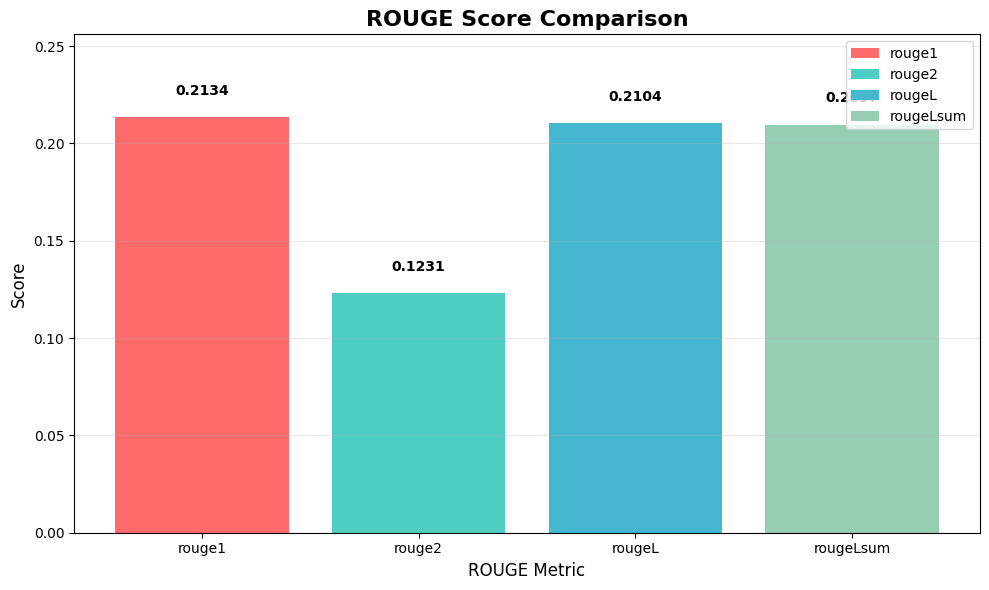

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Colab 환경)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ROUGE 스코어 시각화
def plot_rouge_scores():
    """ROUGE 스코어를 막대 그래프로 시각화"""
    rouge_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
    rouge_values = [rouge_results[metric] for metric in rouge_metrics]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(rouge_metrics, rouge_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])

    # 값 표시
    for bar, value in zip(bars, rouge_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.title('ROUGE Score Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('ROUGE Metric', fontsize=12)
    plt.ylim(0, max(rouge_values) * 1.2)
    plt.grid(axis='y', alpha=0.3)

    # 색상 범례 추가
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=metric)
                      for color, metric in zip(colors, rouge_metrics)]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# ROUGE 스코어 시각화
plot_rouge_scores()

## 4. 요약 품질 정성적 분석

In [36]:
def qualitative_analysis(num_samples=5):
    """요약 품질에 대한 정성적 분석"""
    print("=== 요약 품질 정성적 분석 ===")
    print(f"검증 데이터셋에서 {num_samples}개 샘플 분석\n")

    for i in range(min(num_samples, len(valid_processed))):
        example = valid_processed[i]
        original_text = example["text"]
        reference_summary = example["summary"]

        # 요약 생성
        generated_summary = summarizer(original_text, max_length=128, min_length=30, do_sample=False)[0]['summary_text']

        print(f"�� 샘플 {i+1}")
        print(f"원문 길이: {len(original_text)}자")
        print(f"원문: {original_text[:150]}...")
        print(f"참조 요약: {reference_summary}")
        print(f"생성 요약: {generated_summary}")

        # 품질 평가 (간단한 지표)
        ref_words = len(reference_summary.split())
        gen_words = len(generated_summary.split())
        compression_ratio = len(generated_summary) / len(original_text) * 100

        print(f"요약 길이: {gen_words}단어 (참조: {ref_words}단어)")
        print(f"압축률: {compression_ratio:.1f}%")

        # 핵심 키워드 포함 여부 확인
        ref_keywords = set(reference_summary.split())
        gen_keywords = set(generated_summary.split())
        keyword_overlap = len(ref_keywords.intersection(gen_keywords)) / len(ref_keywords) * 100

        print(f"키워드 일치도: {keyword_overlap:.1f}%")
        print("-" * 80)
        print()

# 정성적 분석 실행
qualitative_analysis()

Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


=== 요약 품질 정성적 분석 ===
검증 데이터셋에서 5개 샘플 분석



Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


�� 샘플 1
원문 길이: 503자
원문: [1] 취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고, 처분 등이 있은 날부터 1년을 경과하면 제기하지 못하며( 행정소송법 제20조 제1항, 제2항), 청구취지를 변경하여 구 소가 취하되고 새로운 소가 제기된 것으로 변경되었을 때에 새로운 소에 ...
참조 요약: 취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행정처분에서의 허가에 붙은 기한이 부당하게 짧은 경우에는 이를 허가조건 존속기간으로 보아서 그 기한의 도래로 조건 개정을 고려한다고 해석할 수 있기에, 사도개설허가의 준공검사를 받지 못한 것은 사도개설허가 자체의 존속기간으로 볼 수 없다는 까닭으로 이것이 실효되는 것은 아니다.
생성 요약: [1] 취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고, 처분 등이 있은 날부터 1년을 경과하면 제기하지 못하며( 행정소송법 제20조 제1항, 제2항, 제2항), 청구취지를 변경하여 구 소가 취하되고 새로운 소가 제기된 것으로 변경되었을 때에 새로운 소가 제기된 것으로 제기된 것으로 변경되었을 때에 새로운 소에 대한 제소기간의 준수 등은 원칙적으로 소의 변경이 있은 때를 기준으로 하여야 한다. [2] 일반적으로 행정처분에 효력기간이 정하여져 있는 있는 있는 경우에는 그 기간의 경과로 그 행정처분의 효력은 상실되며, 다만 허가에 붙은 기한이 그 허가된 사업의 성질상 부당하게 짧은 경우에는 이를 그 허가 자체의 존속기간이 아니라 그 허가된 사업의 성질상 성질상 부당하게 짧은 경우에는 이를 그 허가 자체의 존속기간이 아니라 그 허가조건의 존속기간으로 보아 그 기한이 도래함으로써 그 기한이 도래함으로써 그 조건의 개정을 개정을 고려한다는 뜻으로 해석할 수 있다. [3] 사도개설허가에서 정해진 공사기간 내에 사도로 준공검사를 받지 받지 못한 경우, 이 공사기간을 사도개설허가 자체의 존속기간( 존속기간(
요약 길이: 140단어 (참조: 47단어)
압축률: 114

Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


�� 샘플 2
원문 길이: 840자
원문: [1] 항고소송의 대상이 되는 행정처분이라 함은 원칙적으로 행정청의 공법상 행위로서 특정 사항에 대하여 법규에 의한 권리의 설정 또는 의무의 부담을 명하거나 기타 법률상 효과를 발생하게 하는 등으로 일반 국민의 권리의무에 직접 영향을 미치는 행위를 가리키는 것이지만, ...
참조 요약: 항고소송의 대상이 되는 행정처분이란 일반 국민의 권리의무에 직접 영향을 미치는 행위를 가리키는 것으로, 정부 간 항공노선의 개설에 관한 잠정협정 및 비밀양해각서와 건설교통부 내부지침에 의한 항공노선에 대한 운수권배분처분은 항고소송의 대상이 되는 행정처분에 해당하고, 그 처분으로 인해 공익상의 필요에 비해 상대방이 받게 되는 불이익 등이 더욱 큰 경우에는 재량권의 한계를 일탈한 것으로서 그 자체가 위법하다.
생성 요약: [1] [1] 항고소송의 대상이 되는 행정처분이라 함은 원칙적으로 행정청의 공법상 행위로서 특정 사항에 대하여 법 또는 의무의 부담을 명하거나 기타 법률상 법률상 효과를 발생하게 하는 등으로 일반 국민의 권리의무에 직접 영향을 미치는 미치는 행위를 가리키는 것이지만, 어떠한 처분의 근거가 행정규칙에 규정되어 있다고 하더라도, 그 처분이 상대방에게 권리의 설정 또는 의무의 부담을 명하거나 기타 법적인 법률상 법률 법률상 법률상 법률상 법률 그 그 그 그 그 상대방의 권리의무에 직접 영향을 법률 법률 그 그 그 상대방의 권리의무에 직접 영향을 미치는 행위라면, 이 경우에도 항고소송의 대상이 되는 행정처분에 해당한다. [2] 정부 간 항공노선의 개설에 관한 잠정협정 및 비밀양해각서와 건설교통부 내부지침에 의한 항공노선에 대한 운수권배분처분이 항고소송의 대상이 되는 행정처분에 해당한다고 한 사례. [3] 행정행위를 한 처분청은 비록 그 처분 당시에 별다른 하자가 없었고, 또 그 처분 후에 이를 철회할 별도의 법적 근거가 없다 하더라도 원래의 처분을 존속시킬 필요가 없게 된 사정변경이 생겼거나 또는 중대한 공익상의 필요가 발생한 

Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


�� 샘플 3
원문 길이: 420자
원문: 취득세는 본래 재화의 이전이라는 사실 자체를 포착하여 거기에 담세력을 인정하고 부과하는 유통세의 일종으로 취득자가 재화를 사용·수익·처분함으로써 얻을 수 있는 이익을 포착하여 부과하는 것이 아니어서 취득자가 실질적으로 완전한 내용의 소유권을 취득하는가의 여부에 관계없이...
참조 요약: 취득세는 사실상의 취득행위 자체를 과세객체로 하고, 지방세법에 따르면 부동산 취득에 대해 등기·등록 등을 이행하지 아니한 경우라도 사실상으로 취득한 때에는 이를 취득한 것으로 보도록 규정하고 있으므로, 부동산에 관한 점유취득시효가 완성되면 사실상의 취득행위가 존재한다고 봄이 상당하다고 판시한 사례이다.
생성 요약: 취득 취득 본래 재화의 이전이라는 사실 자체를 포착하여 거기에 담세력을 인정하고 부과하는 유통세의 일종으로 취득자가 재화를 사용·수익·처분함으로써 얻을 수 있는 얻을 수 있는 얻을 수 있는 얻을 수 있는 이익을 포착하여 부과하는 것이 아니어서 취득자가 실질적으로 완전한 내용의 소유권을 취득하는가의 여부에 관계없이 사실상의 취득행위 자체를 과세객체로 하는 것이고, 지방세법 제105조 제2항은 취득세의 과세객체가 되는 부동산 취득에 관하여 민법 기타 관계 관계 관계 법 법령에 의한 등기· 등록 등을 이행하지 아니한 경우라도 사실상으로 취득한 때라도 사실상으로 취득한 때에는 이를 취득한 것으로 보도록 규정하고 있으므로, 부동산에 관한 점유취득시효가 완성되면 취득자는 유상승계취득에 있어 잔금이 청산된 경우와 같이 등기명의인에 대하여 소유권이전등기청구권을 가지게 되는 등 그 그 자체로 취득세의 과세등기청구권을 가지게 되는 등 그 그 그 자체로 취득세의 과세객체가 되는 사실상의 취득행위가 존재한다. 있다. 사실상의 취득행위가 존재한다. 있다. 있다. 있다. 있다. 지방세법 제105조 제2항은 취득세의 과세객체가 되는 부동산 취득에 관하여 민법 기타 관계 관계 관계 관계 관계 법 법
요약 길이: 144단어 (참조: 36단어)
압축률: 1

Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


�� 샘플 4
원문 길이: 286자
원문: [1] 행정처분이 당연무효라고 하기 위하여는 처분에 위법사유가 있다는 것만으로는 부족하고 하자가 법규의 중요한 부분을 위반한 중대한 것으로서 객관적으로 명백한 것이어야 하며, 하자의 중대·명백 여부를 판별함에 있어서는 법규의 목적, 의미, 기능 등을 목적론적으로 고찰함...
참조 요약: 행정처분이 당연무효라고 하기 위해서는 하자가 중대, 명백해야 하는데 세관출장소장이 적법한 권한의 위임 없이 한 관세부과처분은 하자가 중대하지만 명백하지 않아서 당연무효가 아니다.
생성 요약: 하고하고한 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그함에함에 있어서는 법규의 목적, 의미, 기능 등을 목적론적으로 고찰함과 동시에 구체적 사안 자체의 특수성에 관하여도 합리적으로 고찰함을한다.한다.한다.한다.한다. [2] [2] [2] [2] 요한다. [2] [2] [2] [2] 적법한 [2] 적법한 또는 또는 또는 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그
요약 길이: 209단어 (참조: 21단어)
압축률: 177.3%
키워드 일치도: 5.0%
--------------------------------------------------------------------------------

�� 샘플 5
원문 길이: 269자
원문: [1] 등록출원한 상표가 상표법 제6조 제1항 제6호의 '간단하고 흔히 있는 표

모델 최적화를 위한 제언

데이터 품질 개선
- 더 많은 훈련 데이터 확보 (현재: 22,514개)
- 데이터 전처리 강화 (불용어 제거, 정규화)
- 데이터 증강 기법 적용 (백번역, 동의어 치환)

모델 아키텍처
- 더 큰 모델 사용 (현재: KoBART-base, 124M 파라미터)
- KoBART-large 또는 T5 모델 고려
- 앙상블 모델 적용

학습 전략
- 학습률 스케줄링 최적화
- 더 긴 학습 시간 (현재: 3 epochs)
- gradient 누적을 통한 더 큰 배치 크기
- Early Stopping 적용

하이퍼파라미터 튜닝
- 학습률 범위: 1e-5 ~ 5e-5
- 배치 크기: 8, 16, 32 테스트
- 드롭아웃 비율 조정
- 가중치 감쇠 최적화